## Setup autoreload, warnings and helper functions

In [2]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, Markdown
def print_heading(string):
    display(Markdown(f"# {string}"))
def print_subheading(string):
    display(Markdown(f"## {string}"))

## Set the visibility of cuda devices (in case your system contains more than one)

In [3]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


## Imports

In [4]:
%matplotlib inline
from config import config
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import cv2
import zipfile
import tensorflow as tf
import wget
import pickle
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from torchvision.datasets.utils import download_url
from datasets import SimpleDataset

from tools import apply_pipeline, crop_step, curry, apply_pipeline_dataset, get_save_step, apply_sequential,curry_sequential, compose_sequential, calculate_accuracy
from tonemapping.tonemapping import tonemap, tonemap_step
from segmentation.segmentation import segment
from pattern_extraction.extract_pattern import extract_pattern
from reidentification.identify import encode_single, encode_pipeline, identify, identify_single, encode_dataset, apply_geometric
from reidentification.visualisation import visualise_match
from reidentification.find_matches import find_matches

/ekaterina/env/norppa/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-06-12 17:30:46.060351: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-06-12 17:30:47.766600: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-06-12 17:30:47.801567: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:83:00.0 name: NVIDIA TITAN RTX computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2023-06-12 17:30:47.801609: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-06-12 17:30:47.804794: I 

## Create a configuration file.
You can change the default parameters in config.py

In [5]:
cfg = config()

2023-06-12 17:30:55.439192: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:83:00.0 name: NVIDIA TITAN RTX computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2023-06-12 17:30:55.439850: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2023-06-12 17:30:55.440033: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-06-12 17:30:55.440186: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-06-12 17:30:55.440202: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 
2023-06-12 17:30:55.440212: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1277] 0:   N 
2023-06-12 17:30:55.441288: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1418] Created TensorFlow device (/job:local

## Path to the dataset

In [36]:
cfg["dataset_dir"] = "/ekaterina/work/data/dataset-0520/segmented/query/"
cfg["dataset_db_dir"] = "/ekaterina/work/data/dataset-0520/segmented/database"

dataset_dir = Path(cfg["dataset_dir"])
dataset_db_dir = Path(cfg["dataset_db_dir"])

print(f'SealID dataset is ready')

SealID dataset is ready


## Create dataset variables

In [37]:
query_dataset = SimpleDataset(dataset_dir)

print(len(query_dataset))

img_data = query_dataset[3]
print(img_data)

1650
(<PIL.Image.Image image mode=RGB size=1501x593 at 0x7F3E6F6D41D0>, {'class_id': 'phs026', 'file': '/ekaterina/work/data/dataset-0520/segmented/query/phs026/IM000306.JPG.result.png', 'dataset_dir': PosixPath('/ekaterina/work/data/dataset-0520/segmented/query')})


## Show an image from the dataset

# Input image

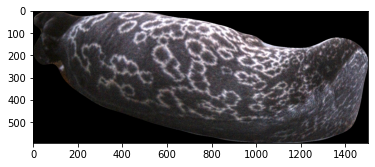

In [38]:
img, label = img_data

print_heading("Input image")
plt.imshow(img)
plt.show()

## Extract pattern

In [39]:
extract_pattern_step = curry(extract_pattern, model=cfg["unet"])

In [43]:
pipeline = [
    apply_sequential(crop_step),
    apply_sequential(extract_pattern_step),
    curry(encode_dataset,cfg=cfg),
]

encoded_dataset = apply_pipeline_dataset(query_dataset, pipeline,verbose=True)

Completed 1/3 steps
Completed 2/3 steps


100%|███████████████████████████████████████| 1650/1650 [53:53<00:00,  1.96s/it]


Calculating PCA


/ekaterina/work/src/NORPPA/repository/NORPPA/reidentification/identify.py:202: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  all_ells = np.array(all_ells)


Getting encoding parameters...
Encoding...
Completed 3/3 steps


## Encode dataset

In [9]:
# encoded_dataset = encode_dataset(pattern_query_dataset, cfg)
# print(len(encoded_dataset))
# print("Encoded dataset")

## Save intermediate steps id needed

In [44]:

# with open("temp/files/encoded_sealid.pickle", 'wb') as f_file:
#     pickle.dump(encoded_dataset, f_file)

In [6]:

with open("temp/files/encoded_sealid.pickle", 'rb') as f_file:
    encoded_dataset = pickle.load(f_file)

## Load database for testing
This example uses a very simple database implemented as a Python class. 

In [45]:
# db_database = DBDatabase("norppa", cfg)

db_dataset = SimpleDataset(dataset_db_dir)
pattern_db_dataset = apply_pipeline_cocodataset(db_dataset, [crop_step,extract_pattern_step], verbose=True)
db_database = encode_dataset(pattern_db_dataset, cfg)

# print(len(db_database.get_fisher_vectors()))
print(len(db_database))
print("Created a test database")

Completed 1/430 images
Completed 2/430 images
Completed 3/430 images
Completed 4/430 images
Completed 5/430 images
Completed 6/430 images
Completed 7/430 images
Completed 8/430 images
Completed 9/430 images
Completed 10/430 images
Completed 11/430 images
Completed 12/430 images
Completed 13/430 images
Completed 14/430 images
Completed 15/430 images
Completed 16/430 images
Completed 17/430 images
Completed 18/430 images
Completed 19/430 images
Completed 20/430 images
Completed 21/430 images
Completed 22/430 images
Completed 23/430 images
Completed 24/430 images
Completed 25/430 images
Completed 26/430 images
Completed 27/430 images
Completed 28/430 images
Completed 29/430 images
Completed 30/430 images
Completed 31/430 images
Completed 32/430 images
Completed 33/430 images
Completed 34/430 images
Completed 35/430 images
Completed 36/430 images
Completed 37/430 images
Completed 38/430 images
Completed 39/430 images
Completed 40/430 images
Completed 41/430 images
Completed 42/430 images
C

  0%|                                                   | 0/430 [00:00<?, ?it/s]/ekaterina/env/norppa/lib/python3.7/site-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/ekaterina/env/norppa/lib/python3.7/site-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
100%|█████████████████████████████████████████| 430/430 [14:21<00:00,  2.00s/it]


Calculating PCA


/ekaterina/work/src/NORPPA/repository/NORPPA/reidentification/identify.py:202: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  all_ells = np.array(all_ells)


Getting encoding parameters...
Encoding...
430
Created a test database


## Perform re-identification with geometric verification

Variable `est_cfg` contains all modifiable parameters the geometric verification utilizes.

Parameters `"method"`, `"max_iters"` and `"max_reproj_err"` changes the behaviour of `cv2.findHomography()`.

`"estimator"` is a function

$\Large E_\Delta = f(d, n, \omega)$

Where $f$ is a arbitarily chosen combination of cosine distance $d$, number of inliers $n$ or fraction of inliers $\omega$.

$\Delta$ is the reprojection error used to classify inliers and outliers when homography is estimated. Since the each point set is translated and scaled inside the unit circle the reprojection error is good to keep between values 0.05 and 0.20 to get sound classification.

Smaller value of $f$ -> better result

Some estimators that can be used:

- $\Large E_\Delta = d(1-\omega)^a$, $\Large a > 0$

- $\Large E_\Delta = d^n$

- $\Large E_\Delta = -n$

In actual use `"estimator"` is a lambda function `lambda d, mask: ...` where mask is a logical array presenting inlier point correspondences, inliers set to 1 and outliers set to 0.

For example $E_\Delta = d^n$ can be determined as `lambda d, mask: d ** np.sum(mask)`

Value of `cfg["topk"]` sets the range for the results to re-order.

In [8]:
cfg["topk"] = 20
    
identification_results = identify(encoded_dataset, encoded_dataset, cfg["topk"], leave_one_out=True)



20


100%|████████████████████████████████████| 1650/1650 [00:00<00:00, 21111.82it/s]


In [9]:
pipeline = [curry_sequential(find_matches, cfg)]
matches = apply_pipeline_dataset(identification_results, pipeline, verbose=True)



/ekaterina/env/norppa/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator PCA from version 1.0.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


/ekaterina/work/src/NORPPA/repository/NORPPA/codebooks/norppa.pickle
Completed 1/1 steps


In [10]:
db_labels = np.array([[x['db_label']['class_id'] for x in y[0]] for y in matches])
q_labels = np.array(query_dataset.get_labels())

hits = (db_labels.T == q_labels).T

probs = [sum((np.sum(hits[:, :j+1], axis=1) > 0)) / len(q_labels)
             for j in range(cfg["topk"])]

_ = [print(f"{100 * p:.6f}", end = " ") for p in probs[:20]]
print()

NameError: name 'query_dataset' is not defined

In [ ]:
pipeline = [curry_sequential(apply_geometric, cfg["geometric"])]
reevaluated = apply_pipeline_dataset(matches, pipeline, verbose=True)

## Calculate the accuracy

In [ ]:
db_labels = np.array([[x['db_label']['class_id'] for x in y[0]] for y in reevaluated])
q_labels = np.array(query_dataset.get_labels())

hits = (db_labels.T == q_labels).T

probs = [sum((np.sum(hits[:, :j+1], axis=1) > 0)) / len(q_labels)
             for j in range(cfg["topk"])]

_ = [print(f"{100 * p:.6f}", end = " ") for p in probs[:20]]
print()

## Visualise re-identification results

Variable `cfg["topk"]` can be changed if smaller quantity of result needs to be inspected.
Additional input parameter `filename` is added that saves a picture of the figure to given path. Saves only the last figure created so its best use is when topk is reset to 1. On default its value is set to `filename=None` (No picture created).


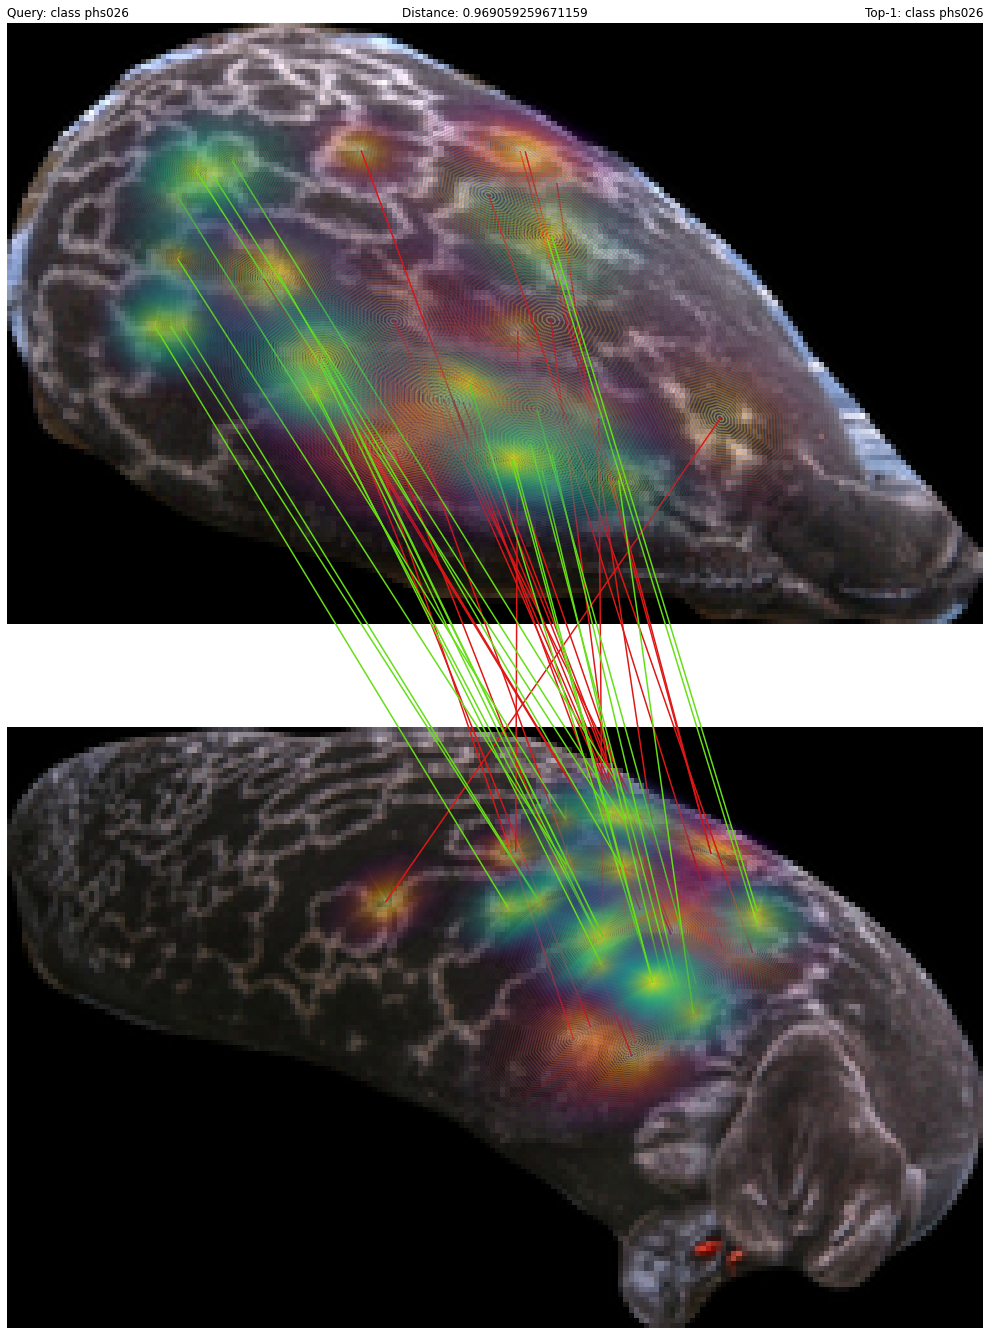

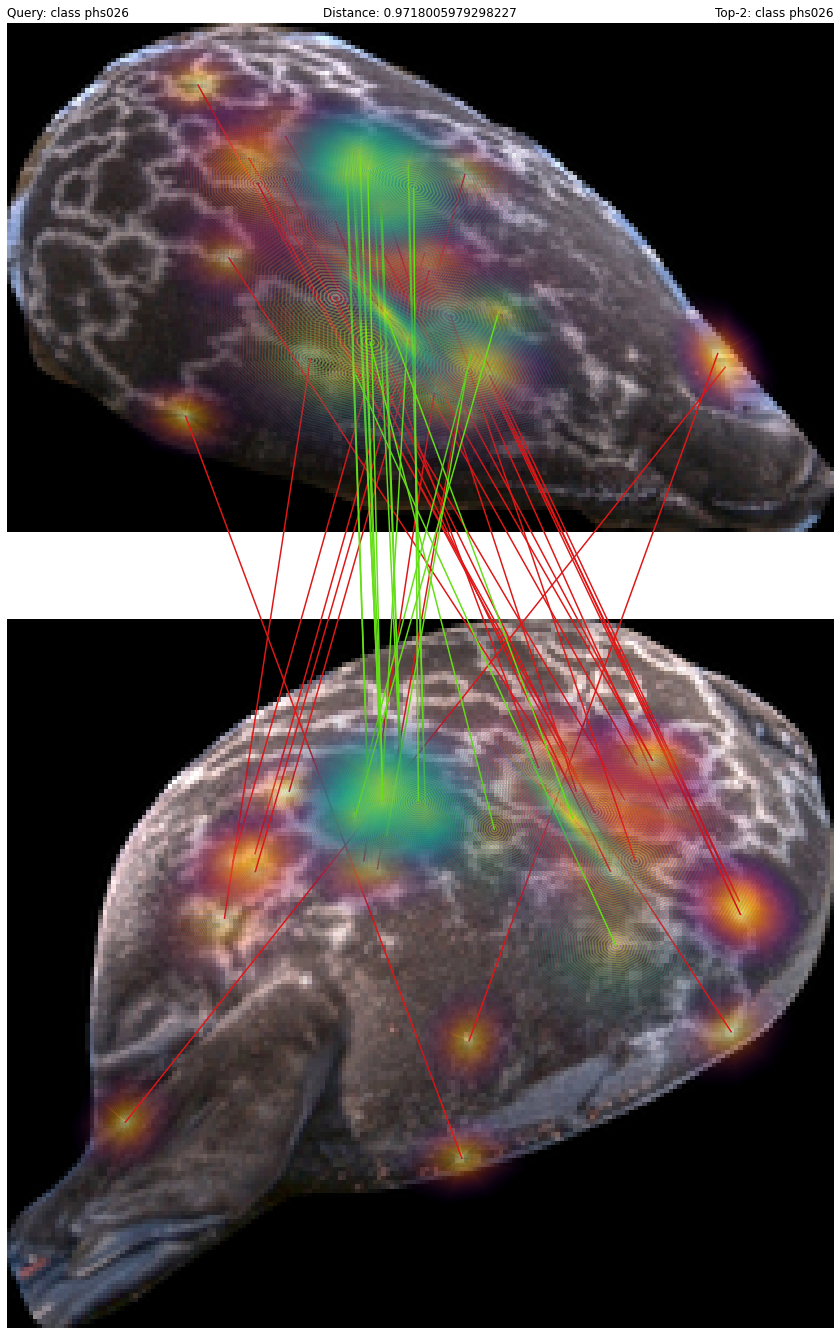

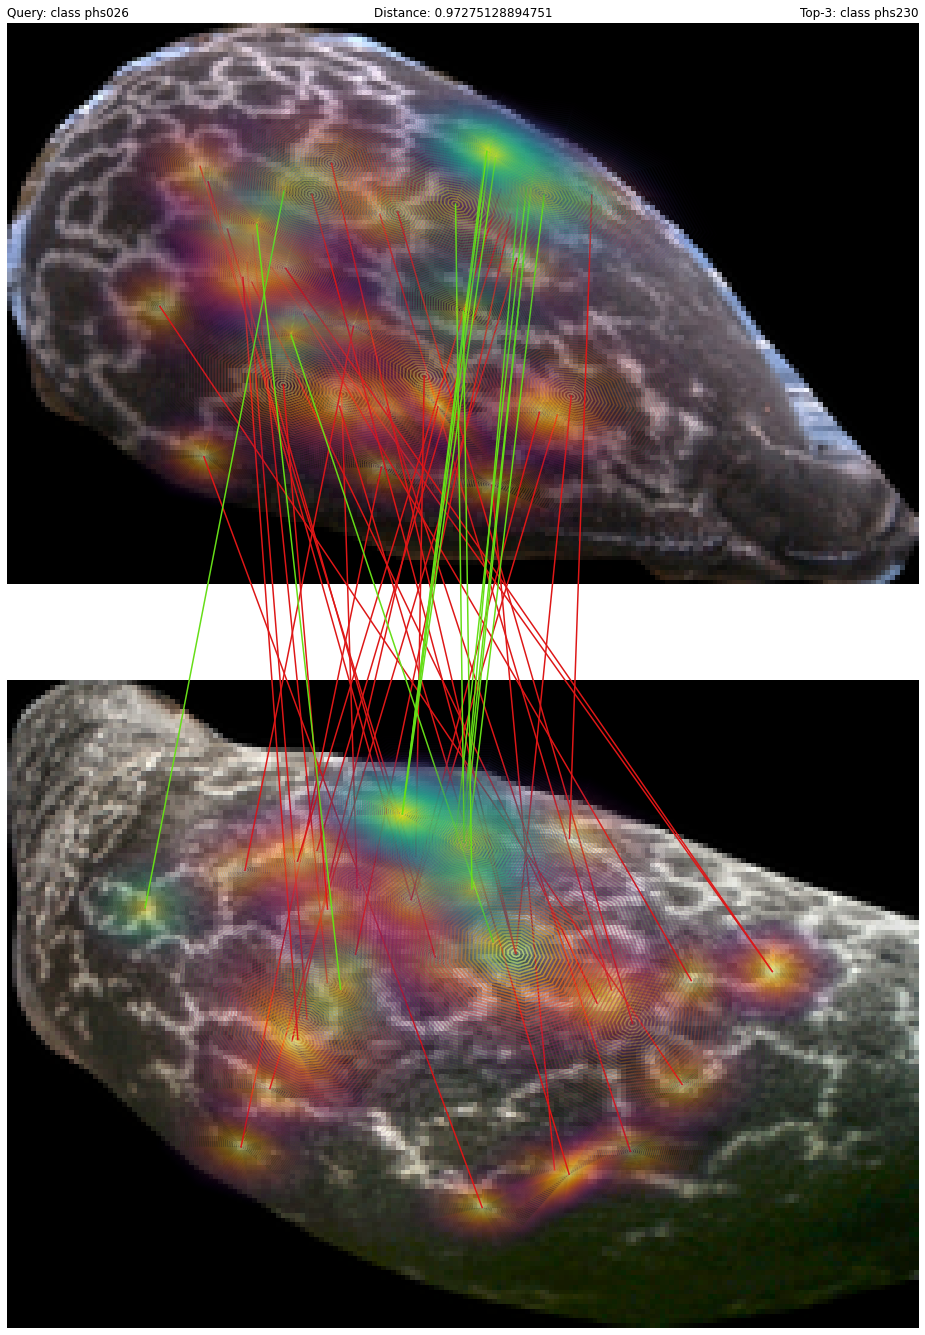

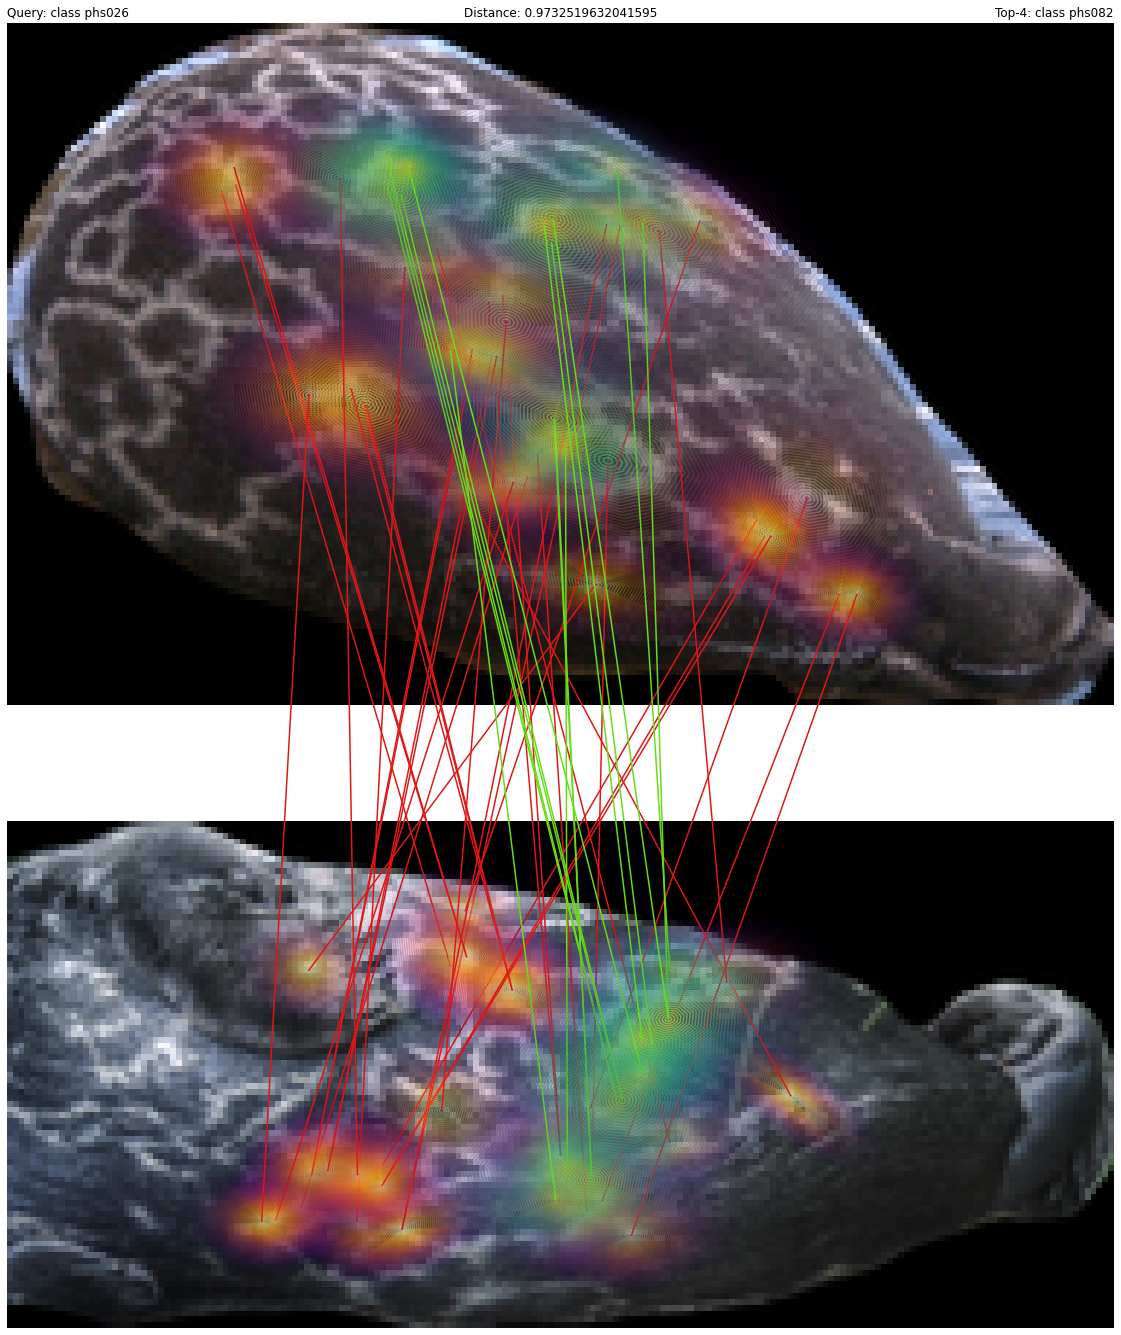

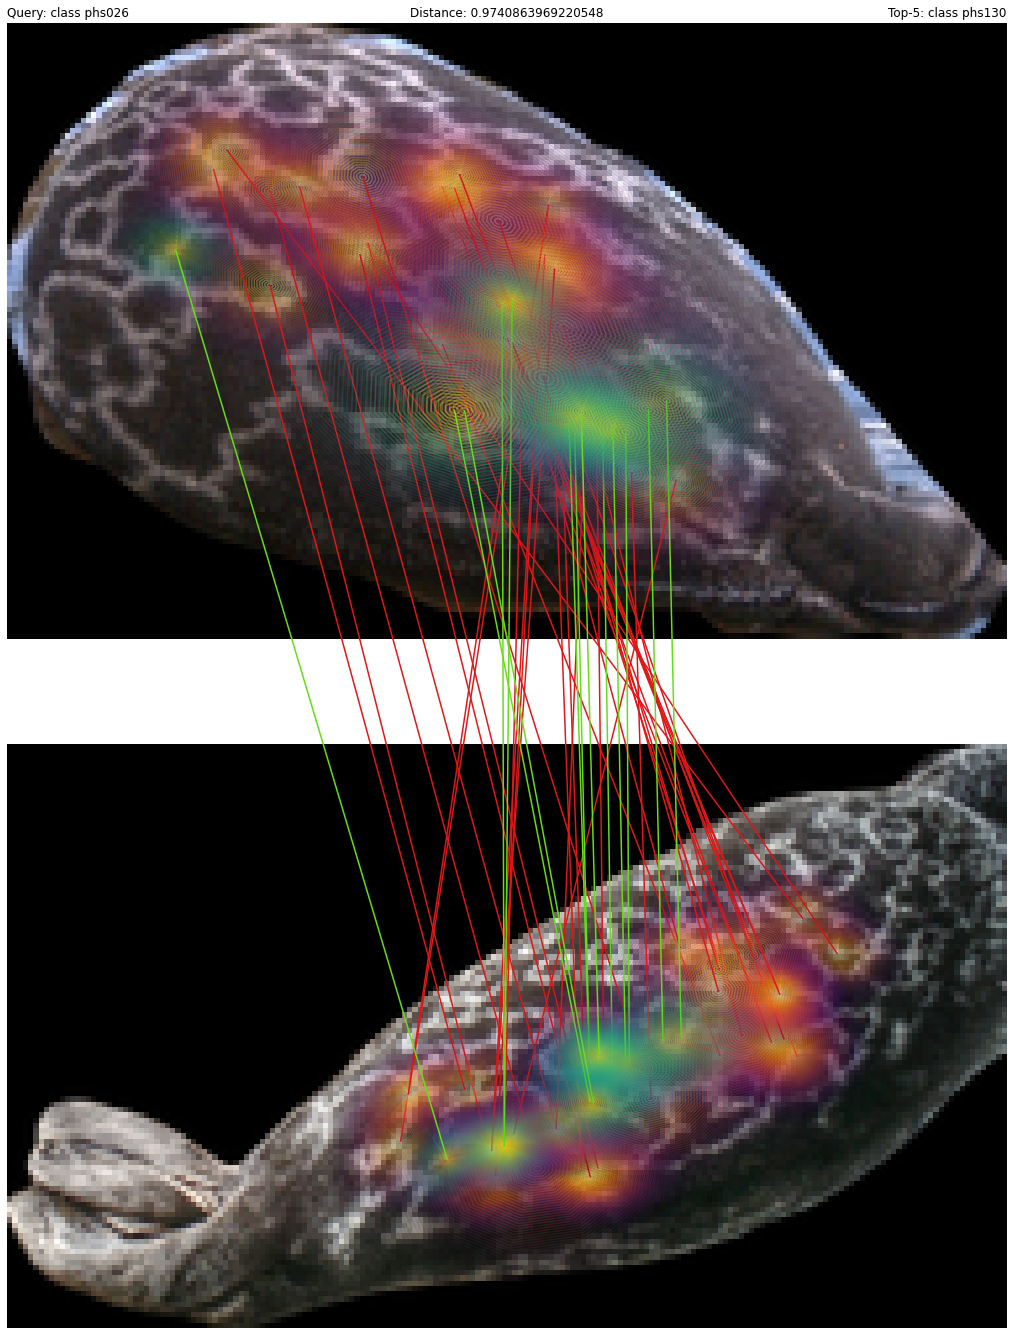

In [83]:
cfg["topk"] = 5

_ = visualise_match(matches[0], cfg["topk"])